In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image


2025-02-17 16:43:02.867889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 16:43:02.868050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 16:43:02.868143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 16:43:06.282223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Select 5 Classes for Classification

# Path to the dataset (change if needed)
dataset_path = "food-101/images"

# Get all available class names
# all_classes = sorted(os.listdir(dataset_path))  # Sorted for consistency

all_classes = os.listdir(dataset_path)

# Select the first 10 classes
selected_classes = all_classes[:10]

# Print selected classes
print("Selected Classes:", selected_classes)



Selected Classes: ['chocolate_mousse', 'ceviche', 'shrimp_and_grits', 'hot_and_sour_soup', 'pork_chop', 'foie_gras', 'grilled_cheese_sandwich', 'poutine', 'huevos_rancheros', 'apple_pie']


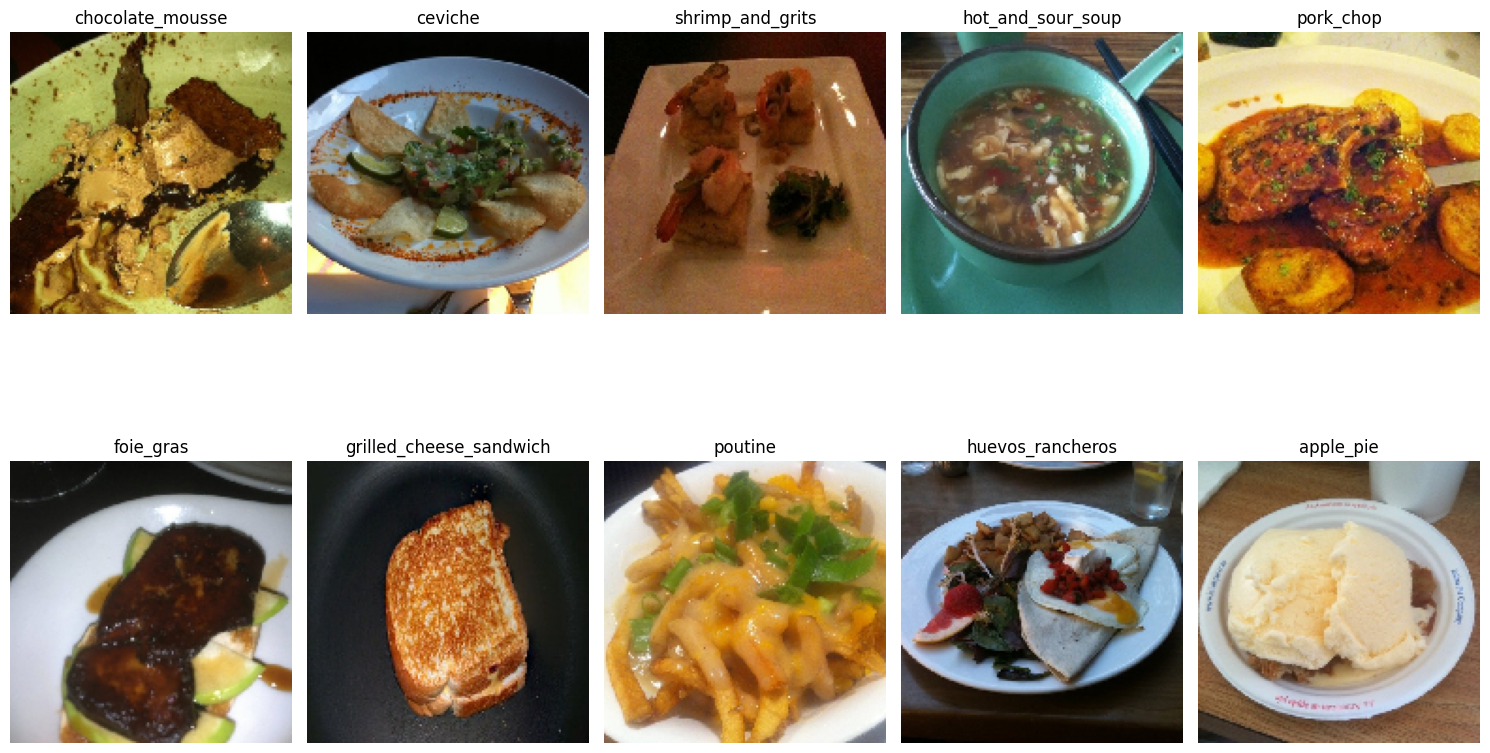

In [3]:
# Plot sample images for each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(selected_classes):
    class_path = os.path.join(dataset_path, class_name)
    class_images = os.listdir(class_path)

    # Select a random image from the class
    random_image_name = random.choice(class_images)
    random_image_path = os.path.join(class_path, random_image_name)
    
    # Load and display the image
    img = image.load_img(random_image_path, target_size=(150, 150))
    plt.subplot(2, 5, i+1)  # Arrange images in a 2x5 grid
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
# Data Preprocessing & Augmentation

# Image settings
img_size = (128, 128)
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=selected_classes,  # Use only selected classes
    subset="training"
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=selected_classes,
    subset="validation"
)

num_classes = len(selected_classes)  # Should be 5


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [5]:
# Load Pretrained InceptionV3 & Modify It

# Load InceptionV3 with pretrained ImageNet weights
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Freeze base model for initial training
base_model.trainable = False  

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)  
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation="softmax")(x)  # Output layer with 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)


In [6]:
# Compile the Model

model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [7]:
# Train the Model with Early Stopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Reduce learning rate if the model stops improving
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6)

epochs = 30  # Start with 10 epochs
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[early_stopping, reduce_lr])


Epoch 1/30
250/250 [==============================] - 365s 1s/step - loss: 2.4880 - accuracy: 0.1161 - val_loss: 2.2870 - val_accuracy: 0.1510 - lr: 1.0000e-04
Epoch 2/30
250/250 [==============================] - 160s 639ms/step - loss: 2.3038 - accuracy: 0.1256 - val_loss: 2.2837 - val_accuracy: 0.1595 - lr: 1.0000e-04
Epoch 3/30
250/250 [==============================] - 155s 620ms/step - loss: 2.2812 - accuracy: 0.1346 - val_loss: 2.2630 - val_accuracy: 0.1655 - lr: 1.0000e-04
Epoch 4/30
250/250 [==============================] - 147s 586ms/step - loss: 2.2706 - accuracy: 0.1461 - val_loss: 2.2511 - val_accuracy: 0.1900 - lr: 1.0000e-04
Epoch 5/30
250/250 [==============================] - 159s 637ms/step - loss: 2.2636 - accuracy: 0.1475 - val_loss: 2.2404 - val_accuracy: 0.1970 - lr: 1.0000e-04
Epoch 6/30
250/250 [==============================] - 139s 554ms/step - loss: 2.2580 - accuracy: 0.1559 - val_loss: 2.2387 - val_accuracy: 0.1815 - lr: 1.0000e-04
Epoch 7/30
250/250 [=====

In [ ]:
# Fine-Tune by Unfreezing Some Layers

# Unfreeze last 30 layers for fine-tuning
for layer in model.layers[-30:]:  
    layer.trainable = True

# Compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train again for fine-tuning
fine_tune_epochs = 5
history_fine = model.fit(train_generator, validation_data=val_generator, epochs=fine_tune_epochs, callbacks=[early_stopping, reduce_lr])


Epoch 1/5
250/250 [==============================] - 199s 714ms/step - loss: 2.2420 - accuracy: 0.1762 - val_loss: 2.1610 - val_accuracy: 0.2135 - lr: 1.0000e-05
Epoch 2/5
250/250 [==============================] - 172s 687ms/step - loss: 2.1933 - accuracy: 0.1925 - val_loss: 2.1380 - val_accuracy: 0.2320 - lr: 1.0000e-05
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 2.1837 - accuracy: 0.1914

In [ ]:
# Evaluate & Plot Accuracy/Loss Graphs

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

# Extract accuracy and loss
train_acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
train_loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(len(train_acc))  # Number of epochs

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()


In [ ]:
# Save the Model for Future Use

model.save("food101_inceptionv3_10classes.h5")